In [48]:
import numpy as np
import matplotlib.pyplot as plt
import build.pybind_modules.dsp_module as cu
import build.pybind_modules.matrix_module as myMatrix
import os
import librosa
from scipy.io import wavfile
from scipy import signal

In [49]:
# Parameters used on tablet 
fs = 48000
nfft = 256
noverlap = -1
nfilt = 40
num_ceps = 13
nn_data_rows = 12
nn_data_cols = 48

In [50]:
def soundDataToFloat(SD):
    "Converts integer representation back into librosa-friendly floats, given a numpy array SD"
    return np.array([ np.float32((s>>2)/(32768.0)) for s in SD])

In [51]:
def createFIR(N, Wn, fs):
 return signal.butter(N, Wn, btype='low', analog=False, output='sos', fs=fs)

In [52]:
raw_data = np.genfromtxt('Mon Apr 17 16:52:52 CDT 2023_rawsamples.csv', delimiter=',', dtype=np.int32)
raw_data_float = np.zeros(len(raw_data), dtype=np.float32)
for i in range(len(raw_data)):
    raw_data_float[i] = float(raw_data[i])
my_data = np.genfromtxt('Wed_Apr_12_000429_CDT_2023_processed.csv', delimiter=',')
my_data = np.reshape(my_data, (12,48))
print("raw_data dtype: {}".format(raw_data.dtype))
print("my_data dtype: {}".format(my_data.dtype))


raw_data dtype: int32
my_data dtype: float64


Text(0.5, 1.0, 'MFCC Conducted on 48 Frames (1 Frame = 5ms)')

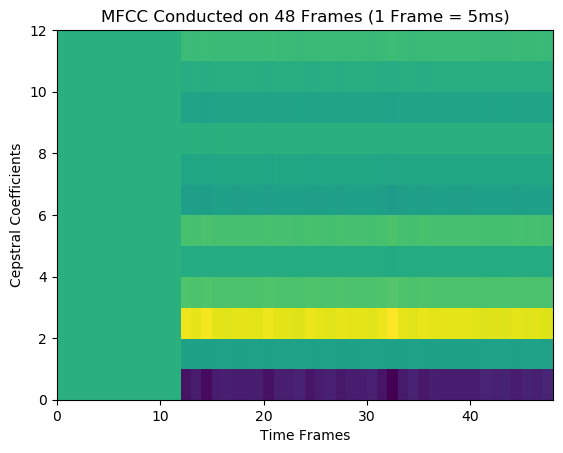

In [53]:
plt.figure()
plt.pcolormesh(my_data)
plt.xlabel("Time Frames")
plt.ylabel("Cepstral Coefficients")
plt.title("MFCC Conducted on 48 Frames (1 Frame = 5ms)")

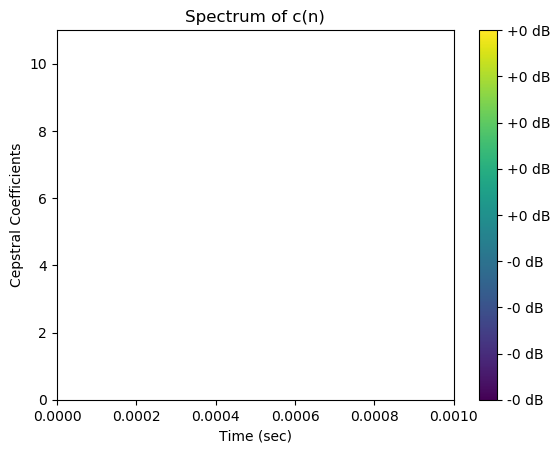

In [54]:
curr_processed = np.array(myMatrix.MFCC_Matrix(list(raw_data_float), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel()
t_time = nn_data_cols / fs
data = np.resize(curr_processed,(nn_data_rows, nn_data_cols))
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")

In [55]:
print(curr_processed)

[nan nan nan ... nan nan nan]


In [58]:
# checking the data type from our dataset
# curr_dir = os.getcwd() + '/' + 'AudioMNIST/data'
# curr_dir = os.getcwd() + '/raw_voice_files/0_jorge/0'
# sig, fs = librosa.load(os.getcwd() + '/raw_voice_files/0_jorge/0'+'/'+'2023_03_24_16_23_23.wav', sr=8000)
# fs, sig = wavfile.read(curr_dir+'/'+'01'+'/'+'0_01_0.wav')
fs, sig = wavfile.read(os.getcwd()+'/raw_voice_files/0_jorge/0/2023_03_24_16_20_10.wav')
# sig = raw_data
print("new fs: {}".format(fs))
print("original dtype: {}".format(sig.dtype))

sig = soundDataToFloat(sig)

sos_filt = createFIR(51, 3500, fs=fs)
filtered_sig = signal.sosfilt(sos_filt, sig)

filtered_sig = np.array([filtered_sig[i] for i in range(0, len(filtered_sig), 6)])
fs = 8000

num_negs = 0
print(sig)
for i in range(len(sig)):
    if sig[i] < 0:
        num_negs += 1

print("Num negs: {}".format(num_negs))
print("Data type: {}".format(sig.dtype))

new fs: 48000
original dtype: int16
[ 0.          0.          0.         ... -0.00027466 -0.00024414
 -0.00024414]
Num negs: 55216
Data type: float32


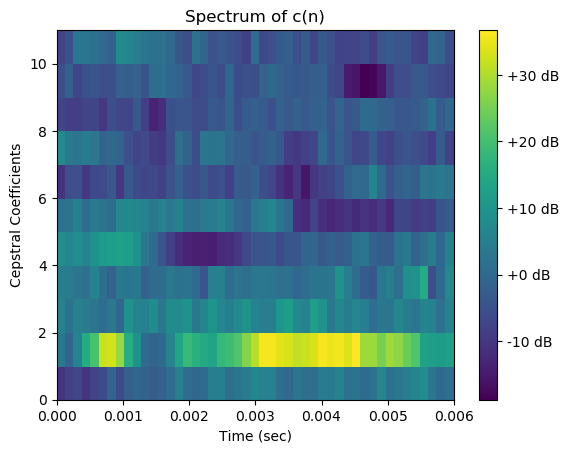

In [59]:
curr_processed = np.array(myMatrix.MFCC_Matrix(list(filtered_sig), fs, nfft, noverlap, 2, 0.6, nfilt, num_ceps), copy=False)[1:,:].ravel()
t_time = nn_data_cols / fs
data = np.resize(curr_processed,(nn_data_rows, nn_data_cols))
t = np.linspace(0, t_time, nn_data_cols)
n = np.arange(nn_data_rows)
plt.title("Spectrum of c(n)")
plt.ylabel("Cepstral Coefficients")
plt.xlabel("Time (sec)")
plt.pcolormesh(t, n, data)
plt.colorbar(format="%+2.f dB")